In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score


0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
387    27.0
388    44.0
389    32.0
390    28.0
391    31.0
Name: mpg, Length: 392, dtype: float64


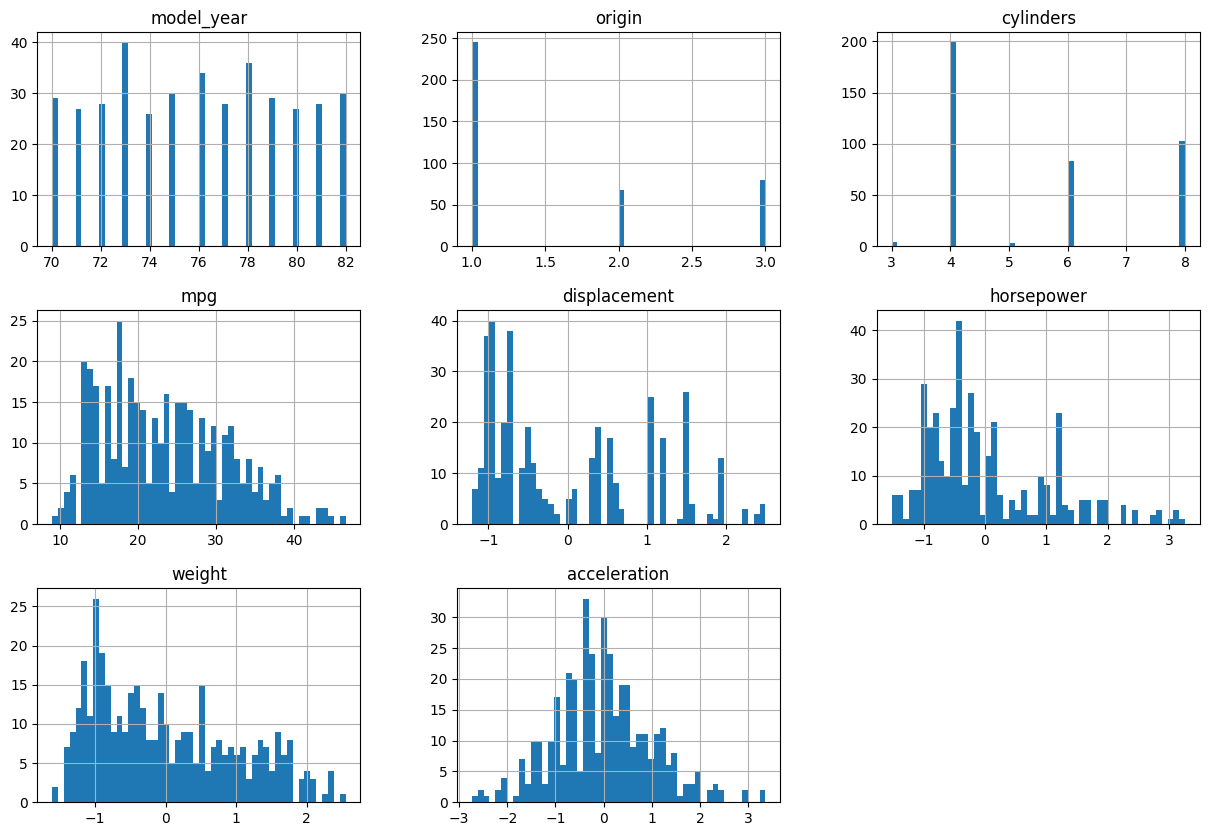

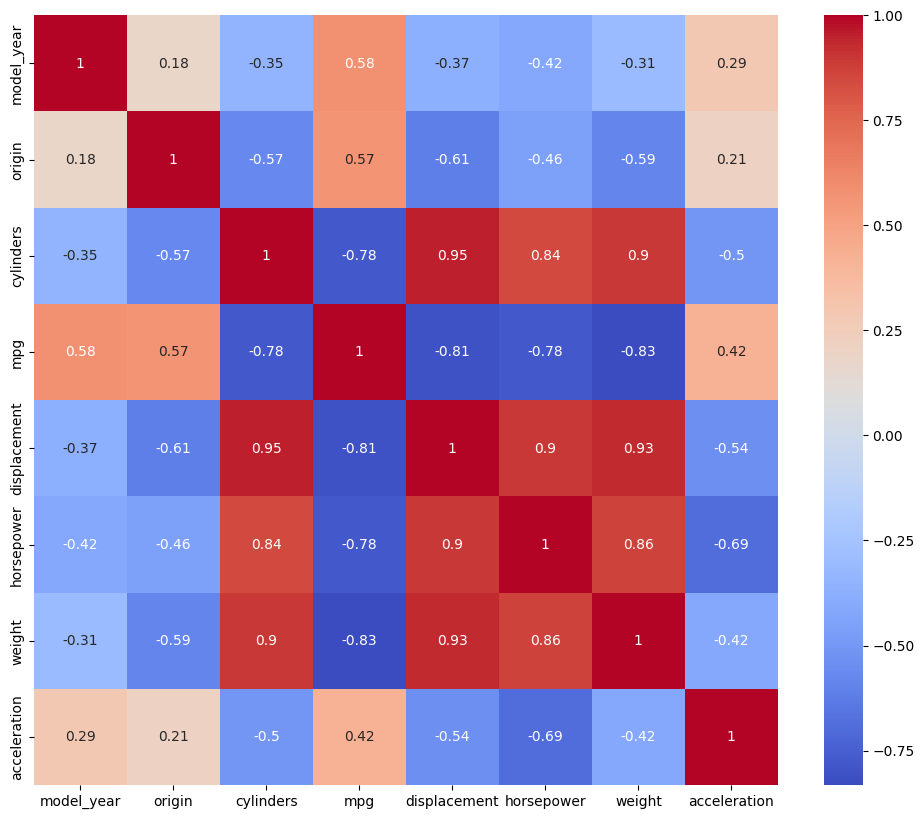

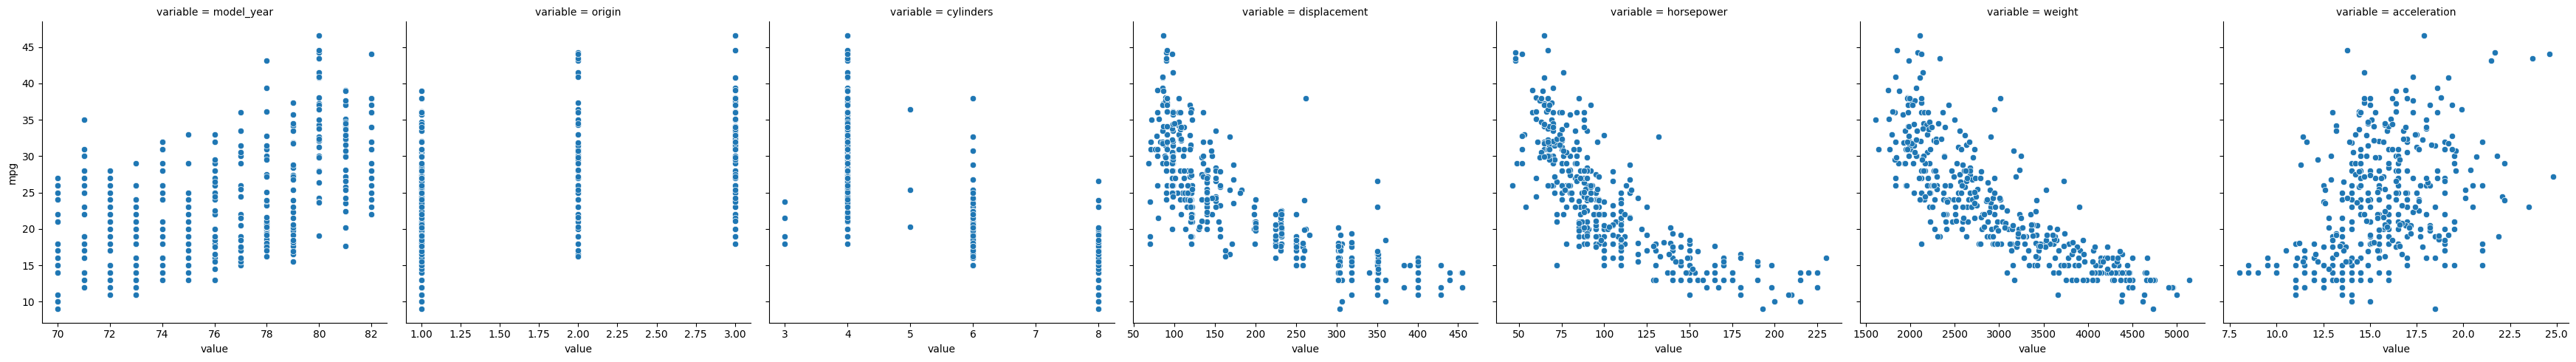

In [43]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

df = pd.read_csv('./auto_1993_adj.csv')
# df.isnull().sum() 6 rows missing horsepower value. Drop those rows
df_dropnull = df.dropna().reset_index(drop=True)

df_dropnull.duplicated().value_counts() # No duplicates

cat_columns = ["ID", "model_year", "origin", "cylinders", "mpg"] # Remove non-quantity features prior to scaling
cat_df = df_dropnull[cat_columns].reset_index(drop=True)
df_subset = df_dropnull.drop(columns=cat_columns) 

scaler = preprocessing.StandardScaler()
df_scaled_vals = scaler.fit_transform(df_subset)
df_scaled = pd.DataFrame(df_scaled_vals, columns=df_subset.columns)

df_final = pd.concat([cat_df, df_scaled], axis=1) # Restore non-quantity features
df_final = df_final.drop(columns="ID")

print(df_final["mpg"])
df_final.hist(bins=50, figsize=(15,10))
corr_matrix = df_final.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

replot_features = list(df_final.columns)
sns.relplot(
    x="value", y="mpg", col="variable", data=df.melt(id_vars="mpg", value_vars=replot_features), facet_kws=dict(sharex=False),
)

weight          0.784938
displacement    0.779453
horsepower      0.732860
cylinders       0.618964
model_year      0.374765
origin          0.239124
acceleration    0.201251
Name: MI Scores, dtype: float64


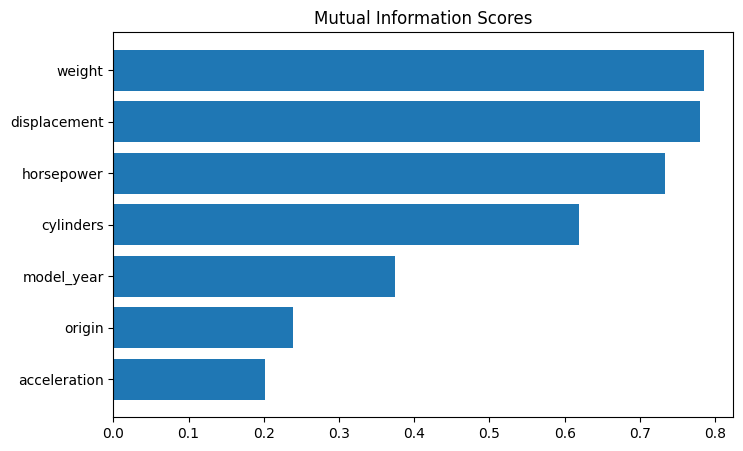

In [44]:
# Split original feature set
X = df_final.drop(["mpg"], axis=1)
y = df_final.mpg

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=16)

# Mutual Info
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = np.array([True, True, True, False, False, False, False])

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)


In [71]:
# Function to run models on each feature set
def run_models(df):
    X = df.drop(["mpg"], axis=1)
    y = df.mpg

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=16)

    knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance')
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)

    lsvr_model = LinearSVR(dual='auto', C=10, epsilon=5, loss='epsilon_insensitive')
    lsvr_model.fit(X_train, y_train)
    lsvr_pred = lsvr_model.predict(X_test)

    ridge_model = Ridge(alpha=0, random_state=2)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)

    # Metrics
    mae_knn = mean_absolute_error(y_test, knn_pred)
    mse_knn = mean_squared_error(y_test, knn_pred)
    r2_knn = r2_score(y_test, knn_pred)

    mae_svr = mean_absolute_error(y_test, lsvr_pred)
    mse_svr = mean_squared_error(y_test, lsvr_pred)
    r2_svr = r2_score(y_test, lsvr_pred)

    mae_ridge = mean_absolute_error(y_test, ridge_pred)
    mse_ridge = mean_squared_error(y_test, ridge_pred)
    r2_ridge = r2_score(y_test, ridge_pred)

    knn_cv = -1 * cross_val_score(knn_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    lsvr_cv = -1 * cross_val_score(lsvr_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    ridge_cv = -1 * cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()

    print("MAE, MSE, R^2, CV-MAE (avg)")
    print("KNN")
    print(mae_knn, mse_knn, r2_knn, knn_cv)
    print("LinearSVR")
    print(mae_svr, mse_svr, r2_svr, lsvr_cv)
    print("Ridge")
    print(mae_ridge, mse_ridge, r2_ridge, ridge_cv)

    return {
        "KNN": {"MAE": mae_knn, "MSE": mse_knn, "R²": r2_knn, "CV-MAE": knn_cv},
        "LinearSVR": {"MAE": mae_svr, "MSE": mse_svr, "R²": r2_svr, "CV-MAE": lsvr_cv},
        "Ridge": {"MAE": mae_ridge, "MSE": mse_ridge, "R²": r2_ridge, "CV-MAE": ridge_cv}
    }

In [66]:
def tuning(df):
    X = df.drop(["mpg"], axis=1)
    y = df.mpg

    model_params = {
        'KNR': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': list(range(0, 100, 5)),
                'weights': ['uniform', 'distance']
            }
        },
        'linear_svr': {
            'model': LinearSVR(dual=True, random_state=5),
            'params': {
                'epsilon': list(range(0, 100, 5)),
                'C': [10,50,100,150,200],
                'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
            }
        },
        'ridge': {
            'model': Ridge(random_state=2),
            'params': {
                'alpha': list(range(0, 100, 5))
            }
        } 
    } 

    scores = []

    for model_name, mp in model_params.items():
        params_tuning = GridSearchCV(mp['model'], mp['params'], scoring= 'neg_mean_squared_error', cv=5, return_train_score=False)
        params_tuning.fit(X,y)
        scores.append({
            'model': model_name,
            'best_score': -1 * params_tuning.best_score_,
            'best_params': params_tuning.best_params_
        })

    return scores

In [67]:
params_set1 = tuning(df_final)

print(display(pd.DataFrame(params_set1)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

,model,best_score,best_params
0,KNR,11.499124,"{'n_neighbors': 10, 'weights': 'distance'}"
1,linear_svr,17.862018,"{'C': 10, 'epsilon': 5, 'loss': 'epsilon_insen..."
2,ridge,15.060851,{'alpha': 0}


None


In [70]:
# Feature Set 1: All features of original dataset
set1 = run_models(df_final)

# sets_of_features.append(df_final)


MAE, MSE, R^2, CV-MAE (avg)
KNN
2.3755250345692858 10.346964766719871 0.8583889472922575 2.555270933197483
LinearSVR
3.2554835287196675 16.955285614225502 0.7679458760202114 3.361241974513967
Ridge
2.691404246000641 13.01816773500973 0.8218302198911307 3.0018751880393824


In [50]:
# Feature Set 2: displacement, horsepower
df_2 = df_final.copy()
selection = ["displacement", "horsepower", "mpg"]
df_run = df_2[selection].copy()
set2 = run_models(df_run)
set2

MAE, MSE, R^2, CV-MAE (avg)
KNN
3.28469387755102 22.93677142857143 0.6860818200363346 3.3353528075300227
LinearSVR
3.6285545182837344 25.867824445262706 0.6459667222667074 4.013342848959711
Ridge
3.5501073360665525 23.991667396485017 0.6716442596617328 4.042625735515458


{'KNN': {'MAE': 3.28469387755102,
  'MSE': 22.93677142857143,
  'R²': 0.6860818200363346,
  'CV-MAE': 3.3353528075300227},
 'LinearSVR': {'MAE': 3.6285545182837344,
  'MSE': 25.867824445262706,
  'R²': 0.6459667222667074,
  'CV-MAE': 4.013342848959711},
 'Ridge': {'MAE': 3.5501073360665525,
  'MSE': 23.991667396485017,
  'R²': 0.6716442596617328,
  'CV-MAE': 4.042625735515458}}

In [51]:
# Feature Set 3: displacement, horsepower, cylinders, weight
df_3 = df_final.copy()
selection = ["displacement", "horsepower", "cylinders", "weight", "mpg"]
df_run = df_3[selection].copy()
set3 = run_models(df_run)
set3

MAE, MSE, R^2, CV-MAE (avg)
KNN
3.1471428571428572 20.466306122448984 0.719893203428999 3.331015254787407
LinearSVR
3.5770176951460013 24.038358262735517 0.671005237216925 3.77393212670002
Ridge
3.4134331522012515 22.29556045453157 0.6948575879150076 3.8256779973041275


{'KNN': {'MAE': 3.1471428571428572,
  'MSE': 20.466306122448984,
  'R²': 0.719893203428999,
  'CV-MAE': 3.331015254787407},
 'LinearSVR': {'MAE': 3.5770176951460013,
  'MSE': 24.038358262735517,
  'R²': 0.671005237216925,
  'CV-MAE': 3.77393212670002},
 'Ridge': {'MAE': 3.4134331522012515,
  'MSE': 22.29556045453157,
  'R²': 0.6948575879150076,
  'CV-MAE': 3.8256779973041275}}

In [52]:
# Feature Set 4: horsepower per cylinder, avg displacement by origin, origin frequency

df_4 = df_final.copy()
df_4["hp_per_cyl"] = df_4.horsepower / df_4.cylinders

df_4["average_origin_disp"] = (
    df_4.groupby("origin")
    ["displacement"]
    .transform("mean")
)

df_4["origin_freq"] = (
    df_4.groupby("origin")
    ["origin"]
    .transform("count")
    / df_4.origin.count()
)

selection = ["hp_per_cyl", "average_origin_disp", "origin_freq", "mpg"]
df_run = df_4[selection].copy()
set4 = run_models(df_run)
set4

MAE, MSE, R^2, CV-MAE (avg)
KNN
3.649387755102041 24.924008163265302 0.6588840192972578 3.6086569295683217
LinearSVR
3.6067898171962987 22.38046185220428 0.6936956069310323 3.7171209883627183
Ridge
3.6433122416924757 21.82509689984845 0.7012964654739213 3.8088258518453246


{'KNN': {'MAE': 3.649387755102041,
  'MSE': 24.924008163265302,
  'R²': 0.6588840192972578,
  'CV-MAE': 3.6086569295683217},
 'LinearSVR': {'MAE': 3.6067898171962987,
  'MSE': 22.38046185220428,
  'R²': 0.6936956069310323,
  'CV-MAE': 3.7171209883627183},
 'Ridge': {'MAE': 3.6433122416924757,
  'MSE': 21.82509689984845,
  'R²': 0.7012964654739213,
  'CV-MAE': 3.8088258518453246}}

In [53]:
# Feature Set 5: displacement, avg displacement by model year, model year
df_5 = df_final.copy()
df_5["avg_disp_by_year"] = (
    df_5.groupby("model_year")
    ["displacement"]
    .transform("mean")
)

selection = ["displacement", "avg_disp_by_year", "model_year", "mpg"]
df_run = df_5[selection].copy()
set5 = run_models(df_run)
set5

MAE, MSE, R^2, CV-MAE (avg)
KNN
2.5148979591836738 10.465285714285718 0.8567695782966201 3.2566004543979226
LinearSVR
8.007504811145116 82.71178850465641 -0.13201346535537772 3.8684667337547554
Ridge
3.289175624156771 18.068926719720924 0.7527043155391067 3.5369472710266505


{'KNN': {'MAE': 2.5148979591836738,
  'MSE': 10.465285714285718,
  'R²': 0.8567695782966201,
  'CV-MAE': 3.2566004543979226},
 'LinearSVR': {'MAE': 8.007504811145116,
  'MSE': 82.71178850465641,
  'R²': -0.13201346535537772,
  'CV-MAE': 3.8684667337547554},
 'Ridge': {'MAE': 3.289175624156771,
  'MSE': 18.068926719720924,
  'R²': 0.7527043155391067,
  'CV-MAE': 3.5369472710266505}}

In [54]:
# Feature Set 6: avg acceleration by cylinders, horsepower, weight, displacement
df_6 = df_final.copy()
df_6["avg_accel_by_cyls"] = (
    df_6.groupby("cylinders")
    ["acceleration"]
    .transform("mean")
)

selection = ["avg_accel_by_cyls", "horsepower", "weight", "displacement", "mpg"]
df_run = df_6[selection].copy()
set6 = run_models(df_run)
set6

MAE, MSE, R^2, CV-MAE (avg)
KNN
3.1642857142857146 20.599130612244902 0.7180753354600398 3.3322765335929887
LinearSVR
3.639037549814997 24.279321997073964 0.6677073494929994 3.7426228115679243
Ridge
3.485561595510618 22.31939545297614 0.6945313763836918 3.8058206155542877


{'KNN': {'MAE': 3.1642857142857146,
  'MSE': 20.599130612244902,
  'R²': 0.7180753354600398,
  'CV-MAE': 3.3322765335929887},
 'LinearSVR': {'MAE': 3.639037549814997,
  'MSE': 24.279321997073964,
  'R²': 0.6677073494929994,
  'CV-MAE': 3.7426228115679243},
 'Ridge': {'MAE': 3.485561595510618,
  'MSE': 22.31939545297614,
  'R²': 0.6945313763836918,
  'CV-MAE': 3.8058206155542877}}

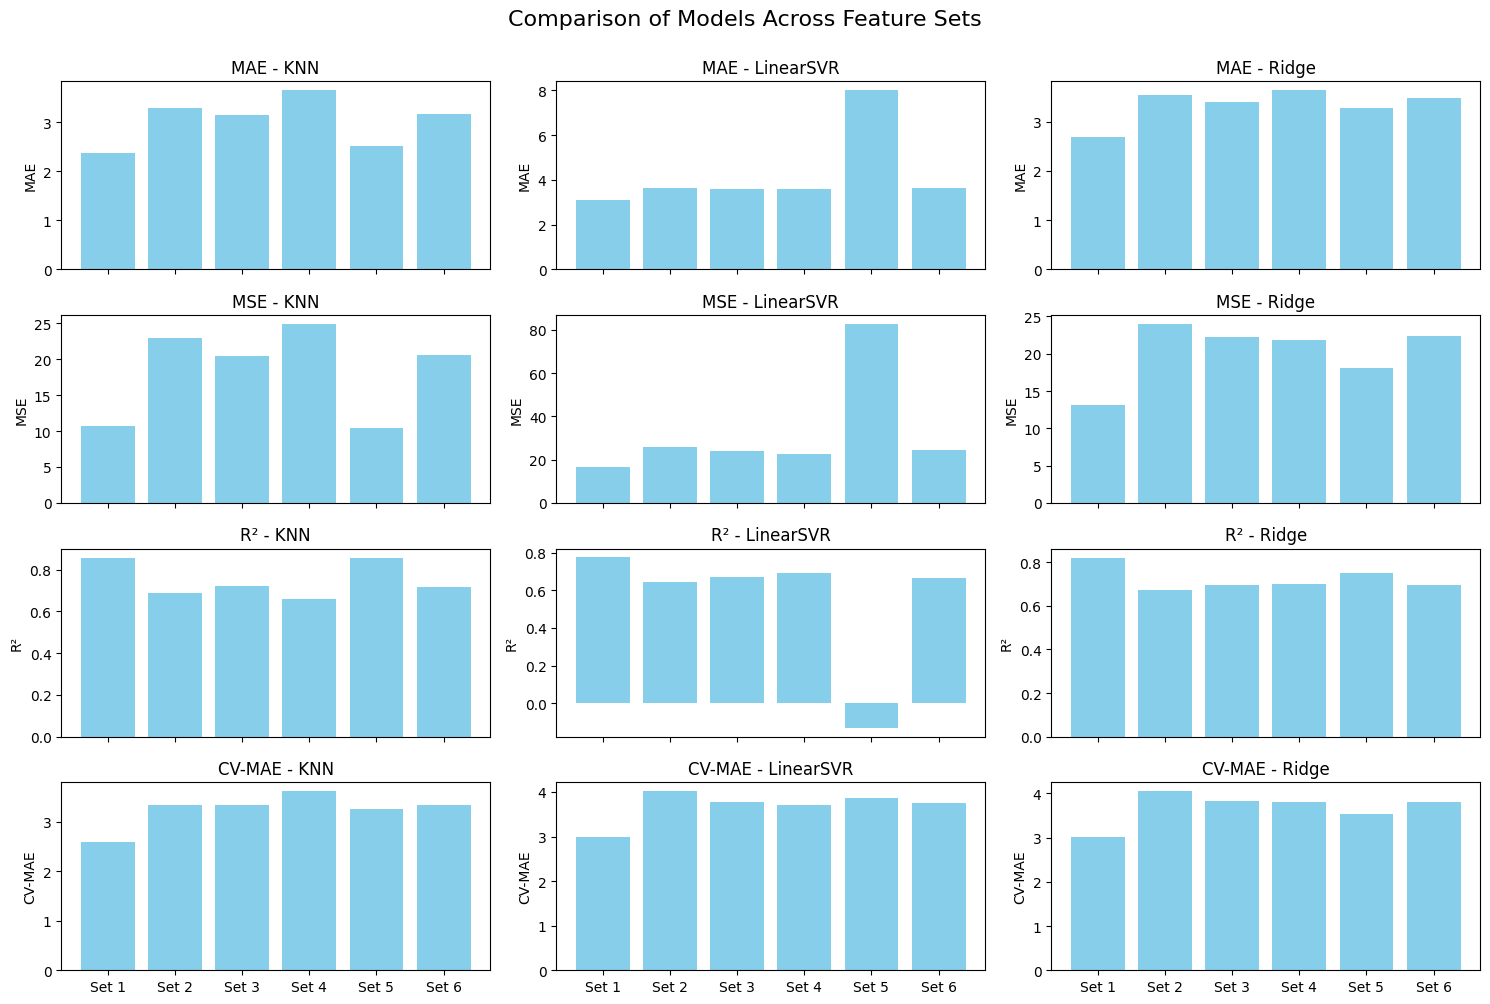

In [55]:
def plot_comparison(sets, metrics):
    models = list(sets[0].keys())  # Assuming all sets have the same models

    fig, axes = plt.subplots(nrows=len(metrics), ncols=len(models), figsize=(15, 10), sharex=True)
    fig.suptitle("Comparison of Models Across Feature Sets", y=1.00, fontsize=16)

    for i, metric in enumerate(metrics):
        for j, model in enumerate(models):
            values = [set_[model][metric] for set_ in sets]
            x_ticks = np.arange(len(sets)) + 1  # For bar positions

            axes[i, j].bar(x_ticks, values, color='skyblue')
            axes[i, j].set_xticks(x_ticks)
            axes[i, j].set_xticklabels([f"Set {k+1}" for k in range(len(sets))])
            axes[i, j].set_ylabel(metric)
            axes[i, j].set_title(f"{metric} - {model}")

    plt.tight_layout()
    plt.show()

# List of feature sets
feature_sets = [set1, set2, set3, set4, set5, set6]

# List of metrics to compare
metrics_to_compare = ["MAE", "MSE", "R²", "CV-MAE"]

# Plot the comparison
plot_comparison(feature_sets, metrics_to_compare)

In [56]:
df_7 = df_final.copy()
display(df_7)

selection = ["cylinders", "horsepower", "weight", "displacement", "mpg"]
df_run = df_7[selection].copy()
set7 = run_models(df_run)
set7

,model_year,origin,cylinders,mpg,displacement,horsepower,weight,acceleration
0,70,1,8,18.0,1.077290,0.664133,0.620540,-1.285258
1,70,1,8,15.0,1.488732,1.574594,0.843334,-1.466724
2,70,1,8,18.0,1.182542,1.184397,0.540382,-1.648189
3,70,1,8,16.0,1.048584,1.184397,0.536845,-1.285258
4,70,1,8,17.0,1.029447,0.924265,0.555706,-1.829655
...,...,...,...,...,...,...,...,...
387,82,1,4,27.0,-0.520637,-0.480448,-0.221125,0.021294
388,82,2,4,44.0,-0.932079,-1.364896,-0.999134,3.287676
389,82,1,4,32.0,-0.568479,-0.532474,-0.804632,-1.430430
390,82,1,4,28.0,-0.712005,-0.662540,-0.415627,1.110088


MAE, MSE, R^2, CV-MAE (avg)
KNN
3.1471428571428572 20.466306122448984 0.719893203428999 3.331015254787407
LinearSVR
3.578970152465894 24.01220177320312 0.6713632212345892 3.7645956454489236
Ridge
3.4134331522012524 22.295560454531564 0.6948575879150077 3.825677997304126


{'KNN': {'MAE': 3.1471428571428572,
  'MSE': 20.466306122448984,
  'R²': 0.719893203428999,
  'CV-MAE': 3.331015254787407},
 'LinearSVR': {'MAE': 3.578970152465894,
  'MSE': 24.01220177320312,
  'R²': 0.6713632212345892,
  'CV-MAE': 3.7645956454489236},
 'Ridge': {'MAE': 3.4134331522012524,
  'MSE': 22.295560454531564,
  'R²': 0.6948575879150077,
  'CV-MAE': 3.825677997304126}}